# Modèle de Classification des genres musicaux

Notebook Classification des genres musicaux :
https://www.kaggle.com/code/danielsheen/spotify-song-genre-classification \
Google Doc rapport :
https://docs.google.com/document/d/1M9s9FF17sJEX5S9xx0gOnQsSh5BbSACHqFkQKUZUak4/edit?tab=t.0 \
Dataset : https://www.kaggle.com/code/sonawanelalitsunil/900k-spotify-songs-with-lyrics-emotions


## Pre-processing

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [16]:
#Chargement du dataset
spotify_df = pd.read_csv("../Dataset/spotify_dataset_class_balanced.csv") #Chargement du dataset possible
spotify_df_80, spotify_df_20= train_test_split(spotify_df, test_size=0.2, random_state=42)


In [17]:
numerical_features = [
    'Tempo',
    'Loudness (db)',
    'Energy',
    'Danceability',
    'Positiveness',
    'Speechiness',
    'Liveness',
    'Acousticness',
    'Instrumentalness',
    'Length',
    'text'
]

categorical_features = [
    'Key',
    'Time signature',
    'emotion'
]

y = spotify_df_80["Main_genre_index"]
X = spotify_df_80[numerical_features + categorical_features ]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42 )


In [18]:


# Prétraitement des données
preprocessing = ColumnTransformer([
    ('num', StandardScaler(), numerical_features), #Standardisation
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),categorical_features) #Encoder
])

preprocessing.fit(X_train)
X_train_pp = preprocessing.transform(X_train)
X_test_pp = preprocessing.transform(X_test)

## Création des modèles de classification

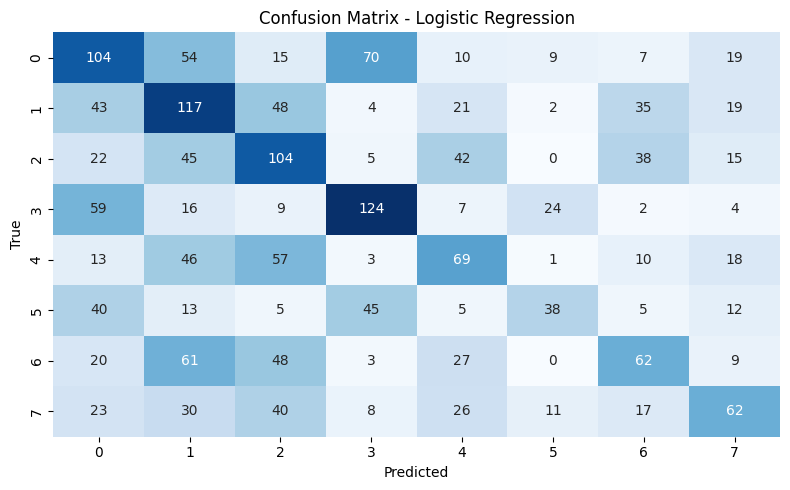

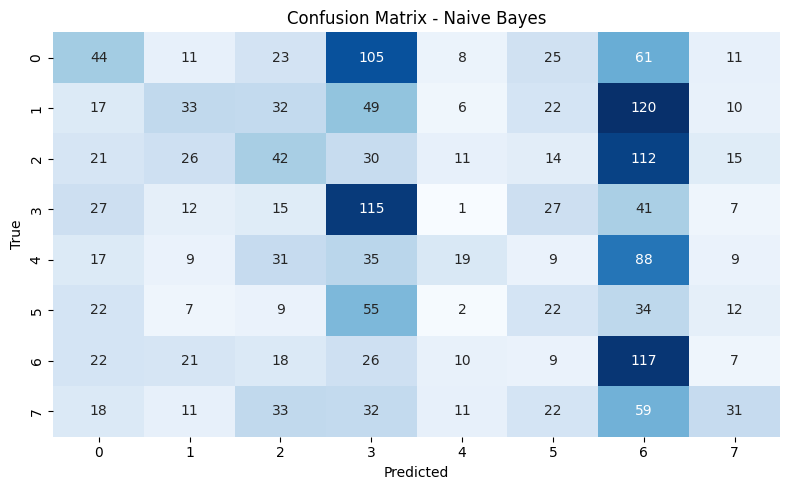

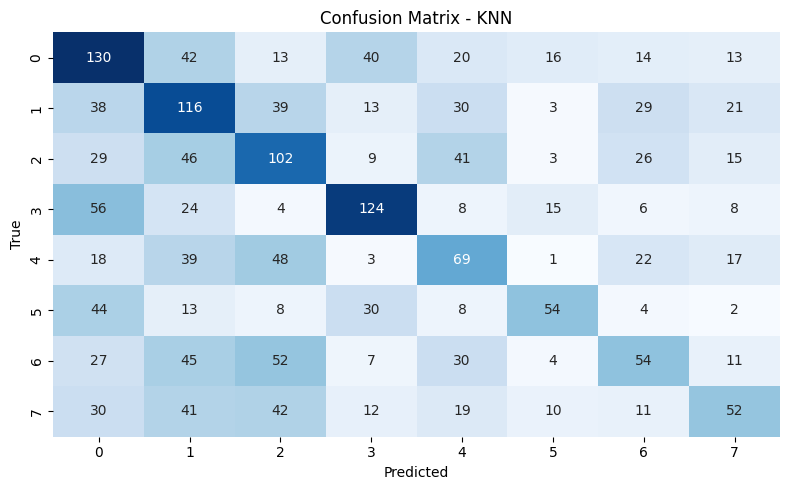

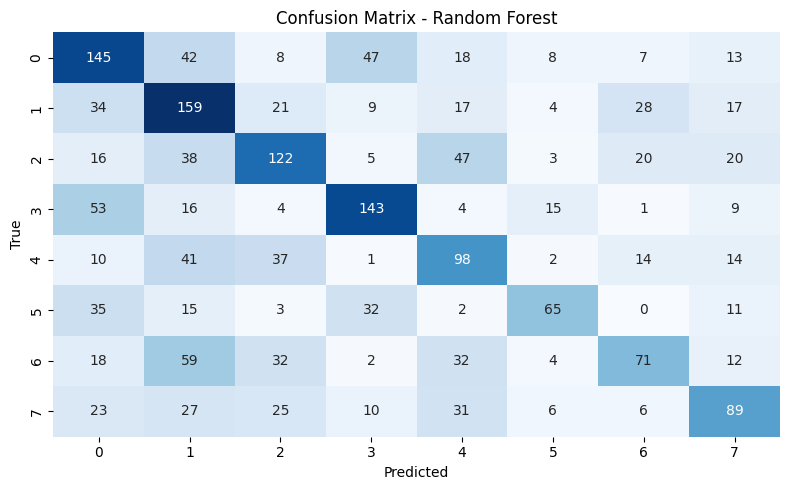

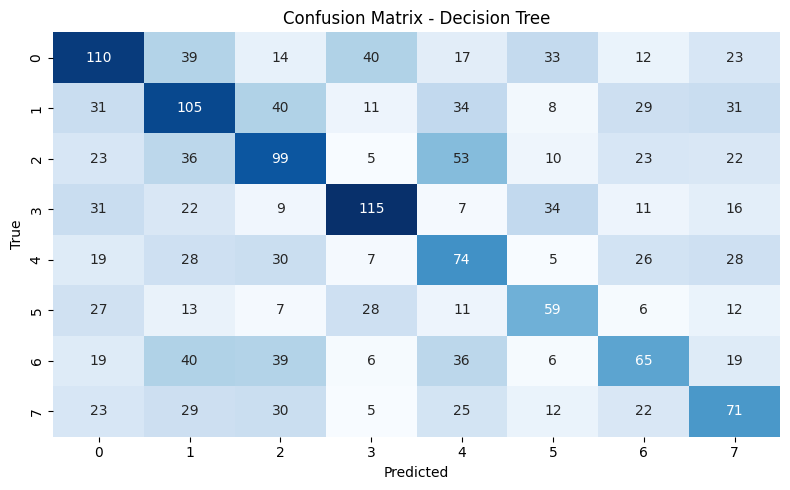

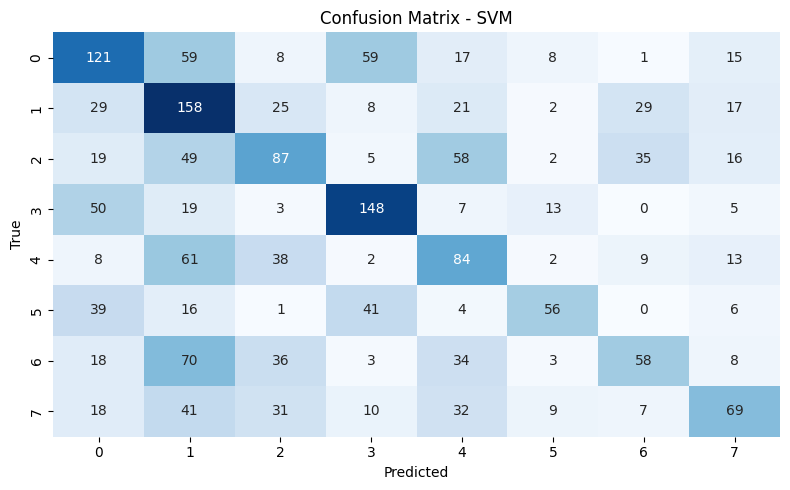

In [19]:
import math

# Modèles
models = [
    LogisticRegression(max_iter=1000,random_state=42),
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=5),
    RandomForestClassifier(n_estimators=100,random_state=42),
    DecisionTreeClassifier(random_state=42),  # Remplace MLP
    SVC(kernel='rbf', C=1, gamma='scale')
]

model_names = [
    'Logistic Regression',
    'Naive Bayes',
    'KNN',
    'Random Forest',
    'Decision Tree',
    'SVM'
]

# Initialisation
n = len(models)
acc_train = [0] * n
acc_test = [0] * n
acc_cv = [0] * n
model_preci = [0] * n
model_recall = [0] * n
model_f1 = [0] * n
y_train_preds = dict()
y_test_preds = dict()

for i in range(n):

    # Apprentissage des modèles et prédictions
    name = model_names[i]
    models[i].fit(X_train_pp, y_train)
    y_train_pred = models[i].predict(X_train_pp)
    y_test_pred = models[i].predict(X_test_pp)

    # Stock des prédictions et de l'accuracy
    y_train_preds[name] = y_train_pred
    y_test_preds[name] = y_test_pred
    
    acc_train[i] = accuracy_score(y_train, y_train_pred)
    acc_test[i] = accuracy_score(y_test, y_test_pred)
    
    acc_cv[i] = np.mean(cross_val_score(models[i], X_train_pp, y_train, cv=5, scoring='accuracy'))
    model_preci[i] = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    model_recall[i] = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    model_f1[i] = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - {model_names[i]}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()




## Analyse général des performances

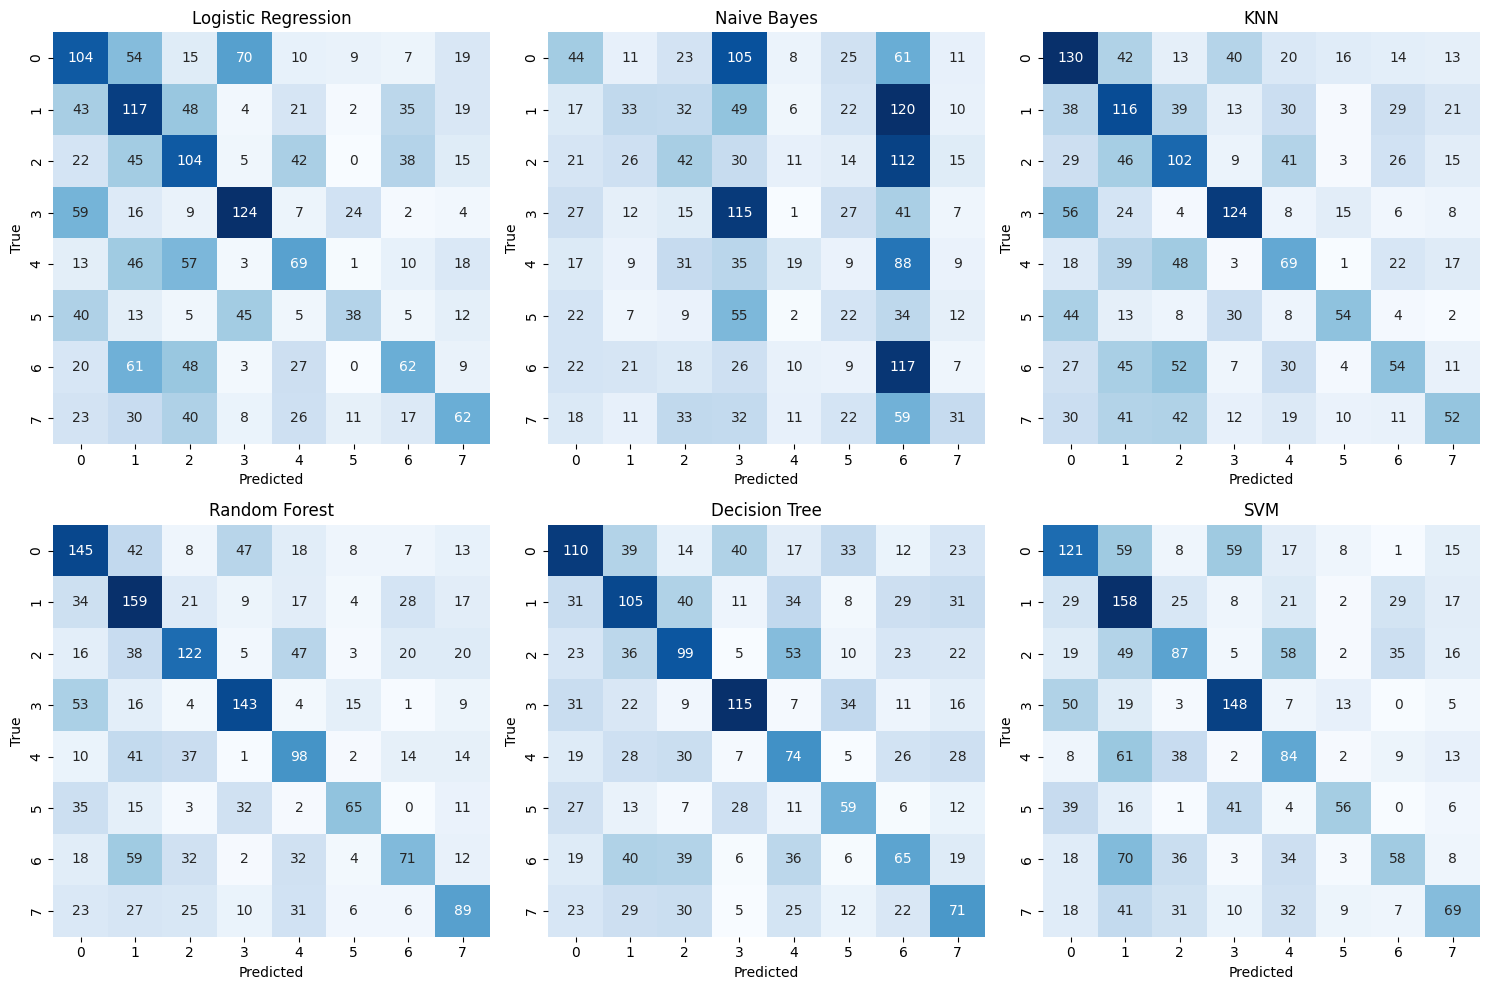

In [20]:
# Affichage des matrices de confusion en subplots
rows = 2
cols = math.ceil(n / rows)  # arrondi supérieur : ici 3 colonnes

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))

axes = axes.flatten()  # pour accéder aux subplots avec axes[i]
for i in range(n):
    name = model_names[i]
    y_test_pred = y_test_preds[name]
    cm = confusion_matrix(y_test, y_test_pred)

    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f"{name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

# Masquer les subplots inutilisés (si n < rows*cols)
for j in range(n, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Nom du modèle       | Accuracy train | Accuracy test
Logistic Regression  | 0.366         | 0.354 
Naive Bayes          | 0.260         | 0.220 
KNN                  | 0.565         | 0.365 
Random Forest        | 1.000         | 0.465 
Decision Tree        | 1.000         | 0.364 
SVM                  | 0.504         | 0.407 


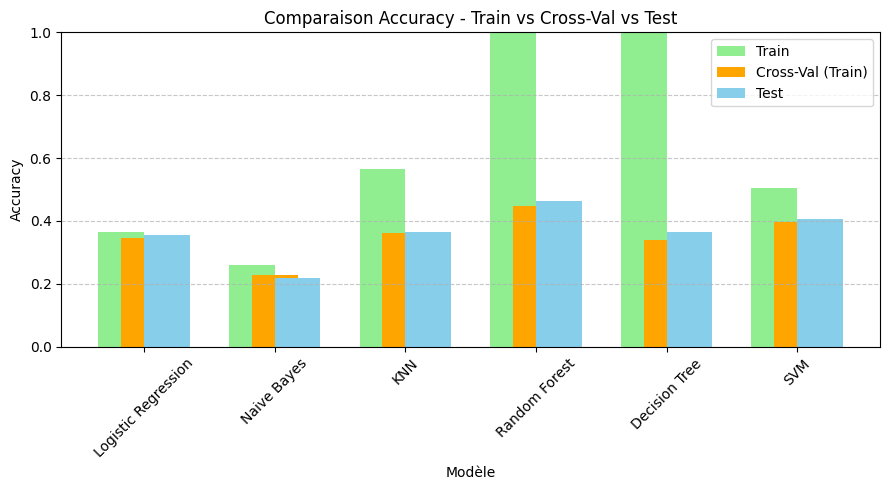

In [21]:
# Entraînement et évaluation
print("Nom du modèle       | Accuracy train | Accuracy test")
for i in range(n):
    print(f"{model_names[i]:20} | {acc_train[i]:.3f}         | {acc_test[i]:.3f} ")

# Histogramme train vs test
x = range(n)
bar_width = 0.35

plt.figure(figsize=(9,5 ))
plt.bar(x, acc_train, width=bar_width, label='Train', color='lightgreen')
plt.bar([p + bar_width/2 for p in x], acc_cv, width=bar_width, label='Cross-Val (Train)', color='orange')
plt.bar([p + bar_width for p in x], acc_test, width=bar_width, label='Test', color='skyblue')

plt.xlabel('Modèle')
plt.ylabel('Accuracy')
plt.title('Comparaison Accuracy - Train vs Cross-Val vs Test')
plt.xticks([p + bar_width/2 for p in x], model_names, rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Analyse des performances de la Régression Logistique

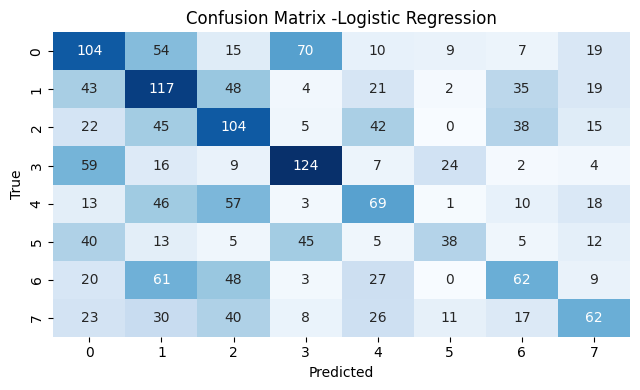

In [22]:
name = 'Logistic Regression'
cm = confusion_matrix(y_test, y_test_preds[name])
plt.figure(figsize=(6.5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix -" + name)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs hyperparamètres : {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Meilleure accuracy moyenne (cross-val) : 0.3447
Accuracy sur le test set : 0.3521
Precision macro sur le test set : 0.3684

Rapport de classification :

              precision    recall  f1-score   support

           0       0.33      0.39      0.36       288
           1       0.30      0.42      0.35       289
           2       0.31      0.41      0.35       271
           3       0.49      0.51      0.50       245
           4       0.33      0.31      0.32       217
           5       0.46      0.19      0.27       163
           6       0.35      0.21      0.27       230
           7       0.37      0.28      0.32       217

    accuracy                           0.35      1920
   macro avg       0.37      0.34      0.34      1920
weighted avg       0.36      0.35      0.35      1920



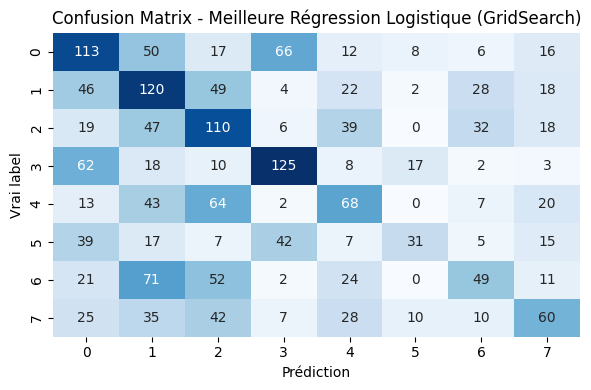

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Définir la grille des hyperparamètres
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [ 0.01, 0.1, 1, 10],
    'solver': ['liblinear'],
    'max_iter': [1000]
}

# Initialisation du modèle
log_reg = LogisticRegression()

# Grid Search avec validation croisée
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Entraînement sur les données prétraitées
grid_search.fit(X_train_pp, y_train)
# Meilleurs paramètres et score
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print(f"Meilleure accuracy moyenne (cross-val) : {grid_search.best_score_:.4f}")

# Évaluation sur le jeu de test
best_model = grid_search.best_estimator_
y_test_pred = best_model.predict(X_test_pp)

acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro', zero_division=0)

print(f"Accuracy sur le test set : {acc:.4f}")
print(f"Precision macro sur le test set : {prec:.4f}")
print("\nRapport de classification :\n")
print(classification_report(y_test, y_test_pred, zero_division=0))

# Affichage de la matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Meilleure Régression Logistique (GridSearch)")
plt.xlabel("Prédiction")
plt.ylabel("Vrai label")
plt.tight_layout()
plt.show()

## K Neighbors Classifier (k=5)


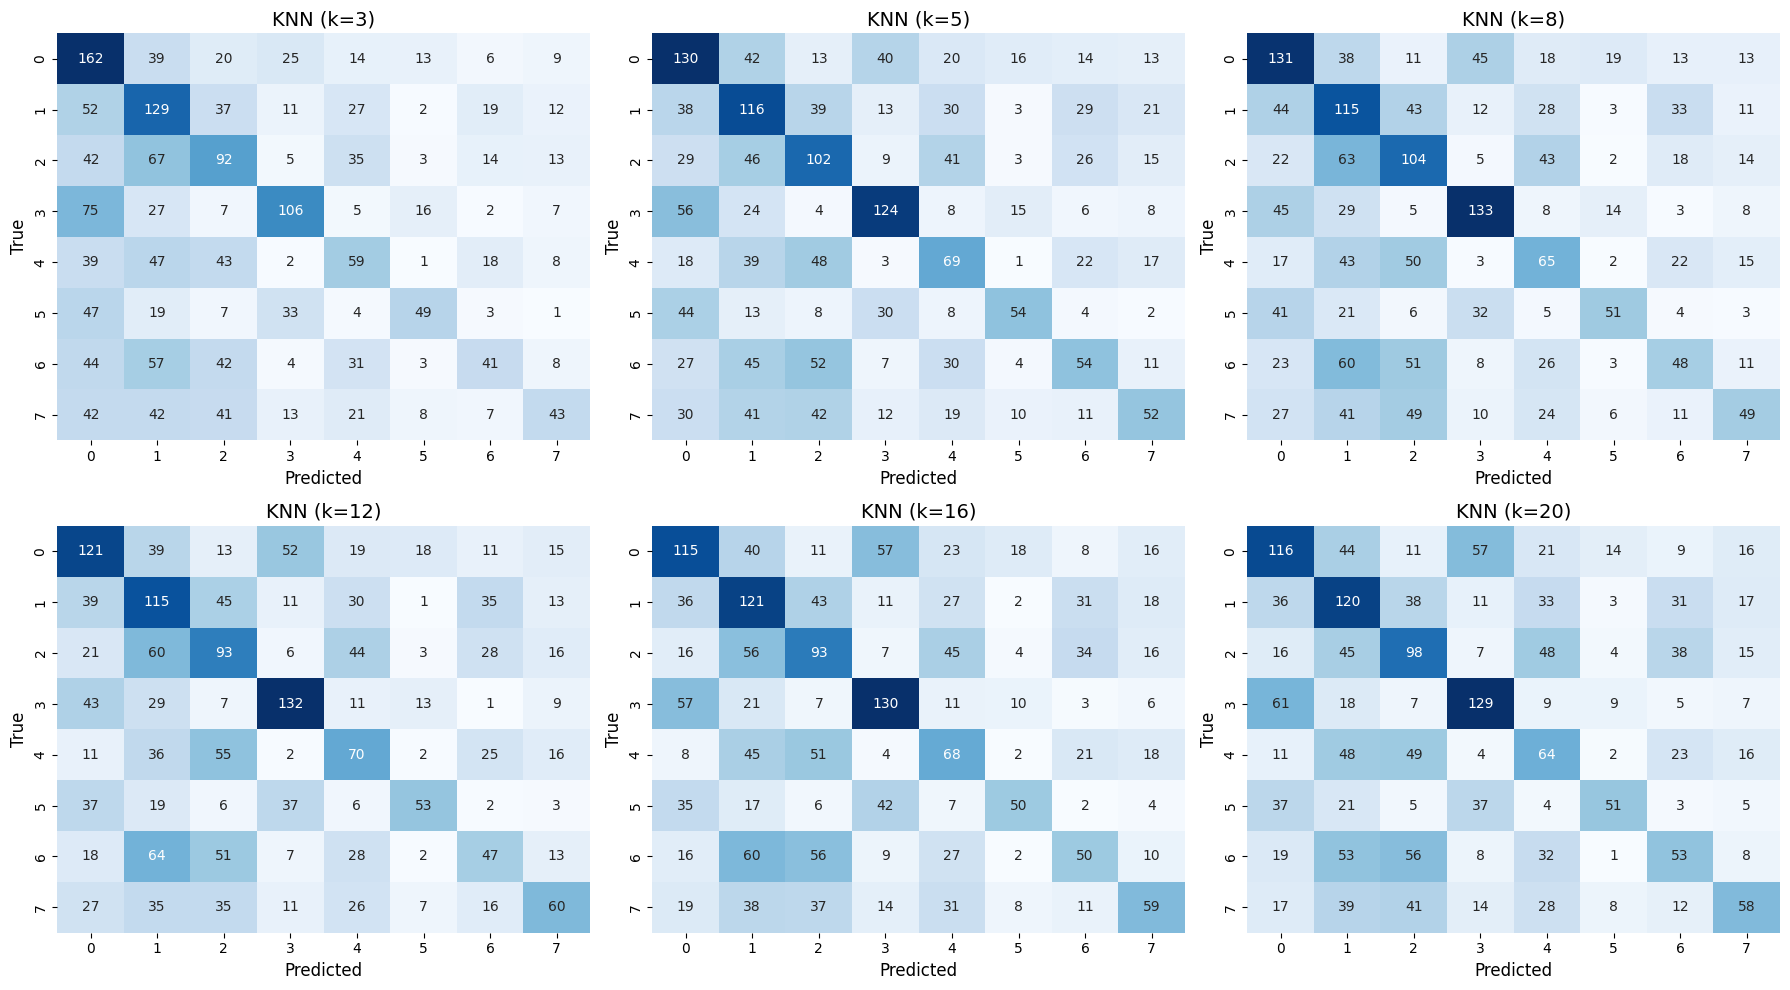

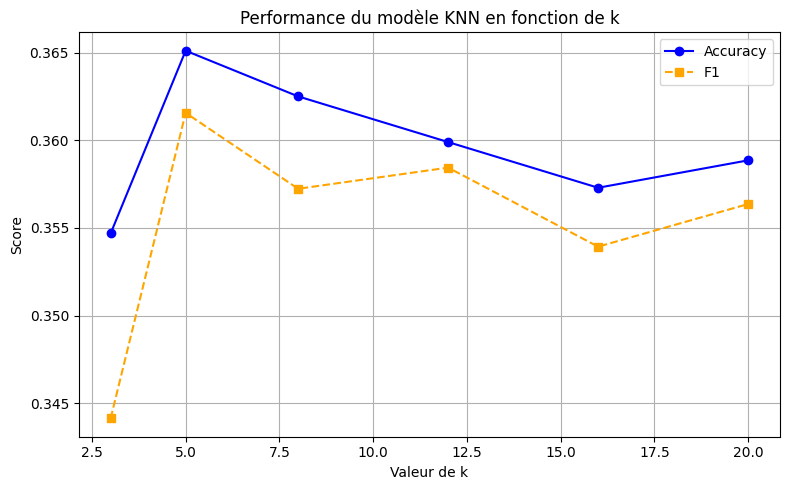

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

ks = [3, 5, 8, 12, 16, 20] # Liste des différents k à tester
accuracy = []
f1 = []
conf_matrices = []

# Entraînement + stockage des métriques et matrices
for k in ks:
    modelKNN = KNeighborsClassifier(k)
    modelKNN.fit(X_train_pp, y_train)
    y_pred = modelKNN.predict(X_test_pp)

    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

    accuracy.append(accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred, average='macro', zero_division=0))

# Affichage en subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 lignes, 3 colonnes
axes = axes.flatten()

for i, k in enumerate(ks):
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(f"KNN (k={k})", fontsize=14)
    axes[i].set_xlabel("Predicted", fontsize=12)
    axes[i].set_ylabel("True", fontsize=12)

plt.tight_layout()
plt.show()

# Tracé
plt.figure(figsize=(8, 5))
plt.plot(ks, accuracy, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.plot(ks, f1, marker='s', linestyle='--', color='orange', label='F1')

plt.title("Performance du modèle KNN en fonction de k")
plt.xlabel("Valeur de k")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Random Forest ( Decision Trees )

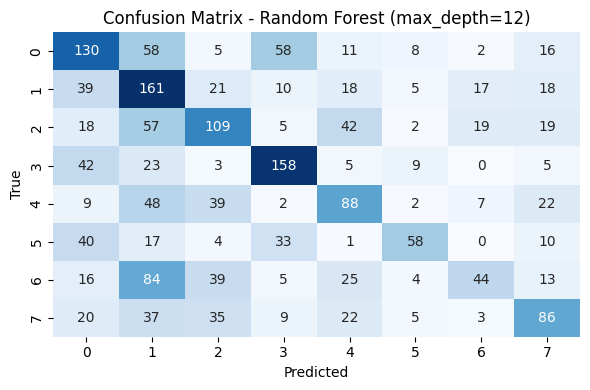

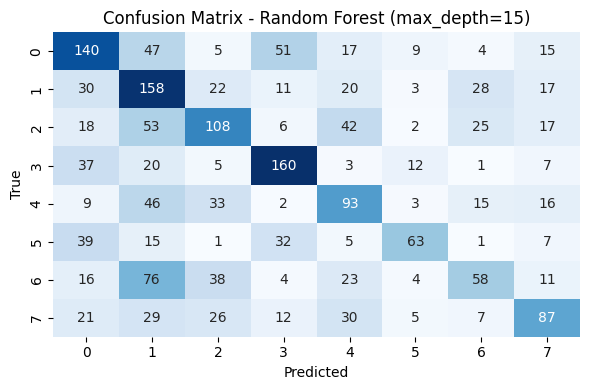

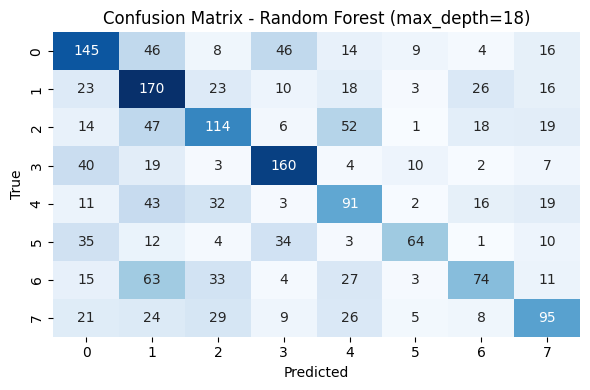

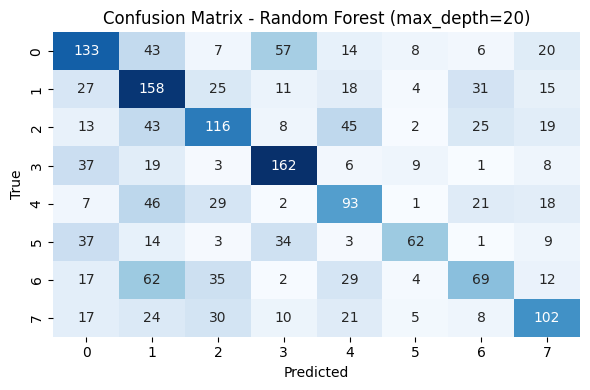

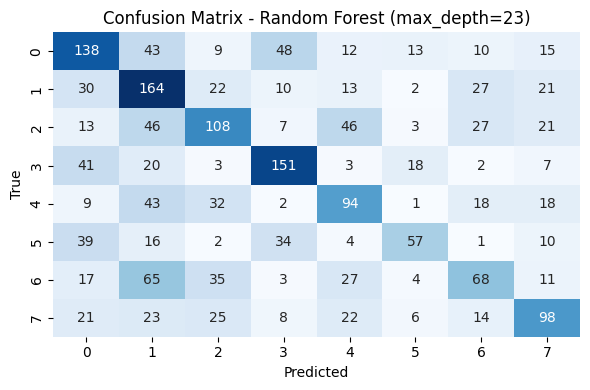

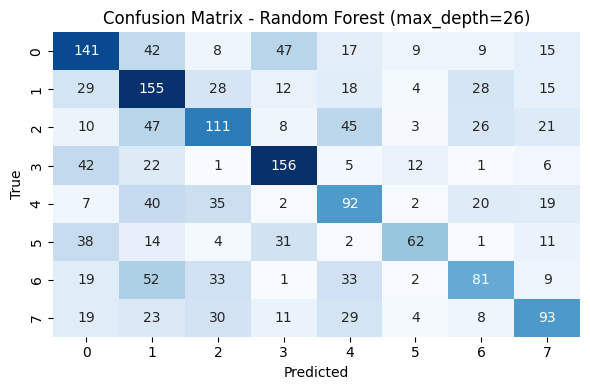

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Profondeurs testées
depths = [12, 15, 18, 20, 23,26 ]

acc_train = []
acc_test = []
acc_cv = []
f1_test = []
conf_matrices = []

# Évaluation pour chaque profondeur
for d in depths:
    modelRF = RandomForestClassifier(max_depth=d, n_estimators=100,random_state=42,min_samples_split=2)
    modelRF.fit(X_train_pp, y_train)

    y_train_pred = modelRF.predict(X_train_pp)
    y_test_pred = modelRF.predict(X_test_pp)

    acc_train.append(accuracy_score(y_train, y_train_pred))
    acc_test.append(accuracy_score(y_test, y_test_pred))
    acc_cv.append(np.mean(cross_val_score(modelRF, X_train_pp, y_train, cv=5, scoring='accuracy')))
    f1_test.append(f1_score(y_test, y_test_pred, average='macro', zero_division=0))

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_test_pred)
    conf_matrices.append(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix - Random Forest (max_depth={d})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


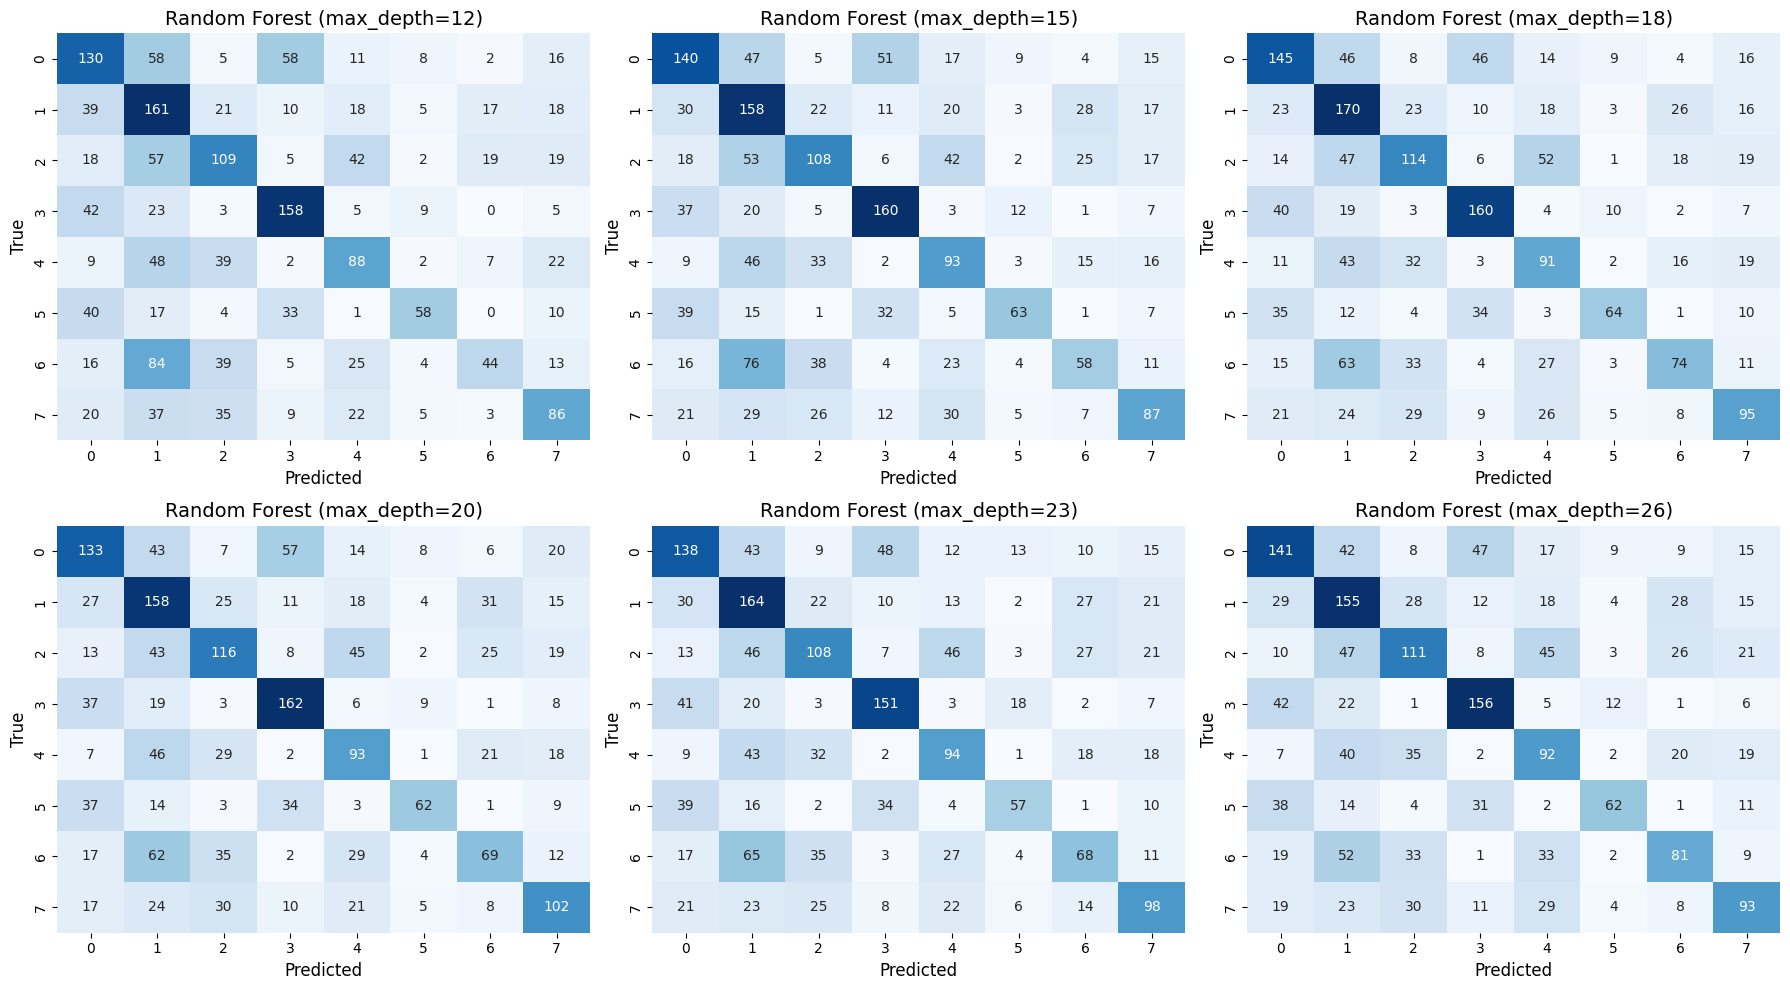

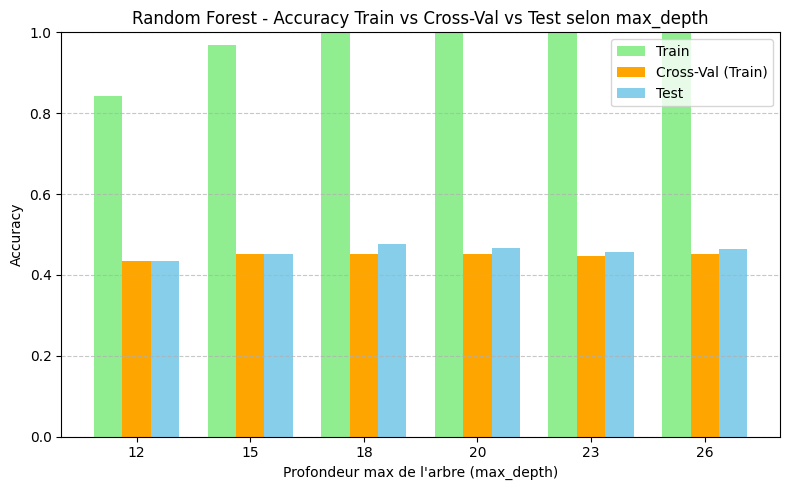

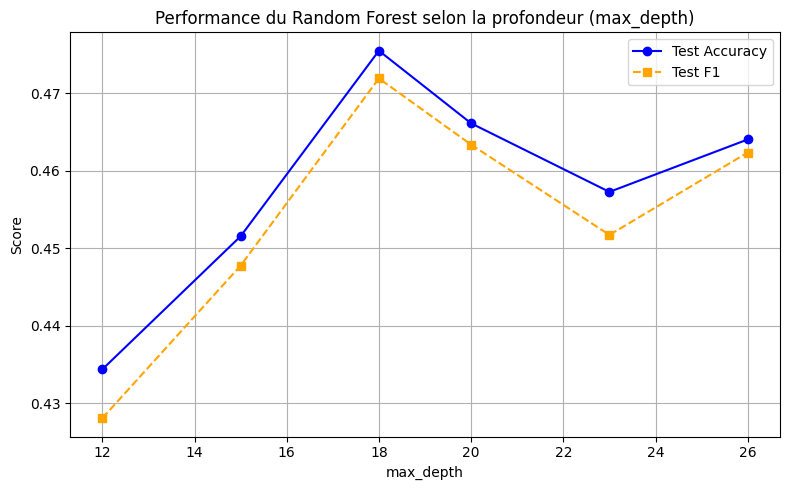

In [26]:
# Subplots des matrices de confusion (2 lignes × 3 colonnes)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 6 subplots
axes = axes.flatten()

for i, d in enumerate(depths):
    sns.heatmap(conf_matrices[i], annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(f"Random Forest (max_depth={d})", fontsize=14)
    axes[i].set_xlabel("Predicted", fontsize=12)
    axes[i].set_ylabel("True", fontsize=12)

plt.tight_layout()
plt.show()

# === Histogramme final : Train / Cross-Val / Test ===
bar_width = 0.25
x = np.arange(len(depths))

plt.figure(figsize=(8, 5))
plt.bar(x, acc_train, width=bar_width, label='Train', color='lightgreen')
plt.bar(x + bar_width, acc_cv, width=bar_width, label='Cross-Val (Train)', color='orange')
plt.bar(x + 2 * bar_width, acc_test, width=bar_width, label='Test', color='skyblue')

plt.xlabel("Profondeur max de l'arbre (max_depth)")
plt.ylabel("Accuracy")
plt.title("Random Forest - Accuracy Train vs Cross-Val vs Test selon max_depth")
plt.xticks(x + bar_width, depths)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === Courbes finale : Accuracy & Precision ===
plt.figure(figsize=(8, 5))
plt.plot(depths, acc_test, marker='o', linestyle='-', color='blue', label='Test Accuracy')
plt.plot(depths, f1_test, marker='s', linestyle='--', color='orange', label='Test F1')

plt.title("Performance du Random Forest selon la profondeur (max_depth)")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()